# Testing PSF stuff

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import votable, fits
from astropy.table import Table
from astropy.nddata import NDData
from photutils.psf import extract_stars, EPSFBuilder
from astropy.visualization import simple_norm
import ldac
import os

data_dir = os.path.expandvars("$SCRATCH/data/curveball/DECam_Reduced/")
# test_psf = data_dir+"2021-09-17/c4d_20210917_031659_r_v1.24.psf.xml"
cat_file = data_dir+"2022-10-02/c4d_20221002_040110_g_v1.24.cat"
img_file = data_dir+"2022-10-02/c4d_20221002_040110_g_v1.24.fits"
mask_file = data_dir+"2022-10-02/c4d_20221002_040110_g_v1.24.mask.fits"

In [2]:
data_dir

'/pscratch/sd/e/eramey16/data/curveball/DECam_Reduced/'

In [3]:
# psfxml = votable.parse( test_psf )

In [4]:
# psfxml

In [5]:
# tables = []
# for table in psfxml.iter_tables():
#     tables.append(table)

In [6]:
# tables[2].array

### Cat file

In [7]:
# Fits Table does not work to extract cat files directly

In [8]:
with fits.open(img_file) as file:
    hdr = file[0].header
    data = file[0].data

with fits.open(mask_file) as file:
    mask_hdr = file[0].header
    mask_data = file[0].data

In [9]:
tbl = ldac.get_table_from_ldac( cat_file )
# Get coords of things we are mostly sure are stars
tbl = tbl[tbl['CLASS_STAR'] > 0.99]
print(len(tbl))
tbl[:5]

16


<Table length=5>
  NUMBER   ID_PARENT  MAG_AUTO ... CLASS_STAR            VIGNET           
                        mag    ...                         ct             
  int32      int32    float32  ...  float32          float32[35,35]       
---------- ---------- -------- ... ---------- ----------------------------
        21         47 -15.7131 ...      1.000     7.221909 ..     6.919632
        34         52 -14.5060 ...      0.992    -4.637207 ..    0.3473358
        97        109 -14.2520 ...      0.993   -0.2110596 ..      7.06044
       138        151 -13.1640 ...      0.991     5.577591 ..    -4.105789
       203        209  -9.6229 ...      0.998     4.730896 ..     3.521027

In [9]:
tbl.columns

<TableColumns names=('NUMBER','ID_PARENT','MAG_AUTO','MAGERR_AUTO','XWIN_IMAGE','YWIN_IMAGE','X_IMAGE','Y_IMAGE','THETAWIN_IMAGE','AWIN_IMAGE','BWIN_IMAGE','ERRAWIN_IMAGE','ERRBWIN_IMAGE','ERRTHETAWIN_IMAGE','X_WORLD','Y_WORLD','THETA_WORLD','ELONGATION','ERRA_WORLD','ERRB_WORLD','ERRTHETA_WORLD','FWHM_IMAGE','FWHM_WORLD','FLUX_AUTO','FLUXERR_AUTO','FLUX_APER','FLUXERR_APER','FLAGS','FLAGS_WEIGHT','IMAFLAGS_ISO','FLUX_MAX','FLUX_RADIUS','SNR_WIN','CLASS_STAR','VIGNET')>

In [9]:
size = 50
hsize = int(size / 2)

x = tbl['X_IMAGE']  
y = tbl['Y_IMAGE']

mask = ((x > hsize) & (x < (data.shape[1] -1 - hsize)) &
        (y > hsize) & (y < (data.shape[0] -1 - hsize)))
size = 25

In [10]:
stars_tbl = Table()
stars_tbl['x'] = x[mask]
stars_tbl['y'] = y[mask]

# idxs = [1,2,10,18,25,28,49,64,88,91,96,135,140,142,147,151,152,153,154,172,179,180,183,184,187]
# stars_tbl = stars_tbl[idxs]

In [11]:
from astropy.stats import sigma_clipped_stats
mean_val, median_val, std_val = sigma_clipped_stats(data, sigma=2.0)

In [12]:
nddata = NDData(data=data)
stars = extract_stars(nddata, stars_tbl, size=25)

IndexError: list index out of range

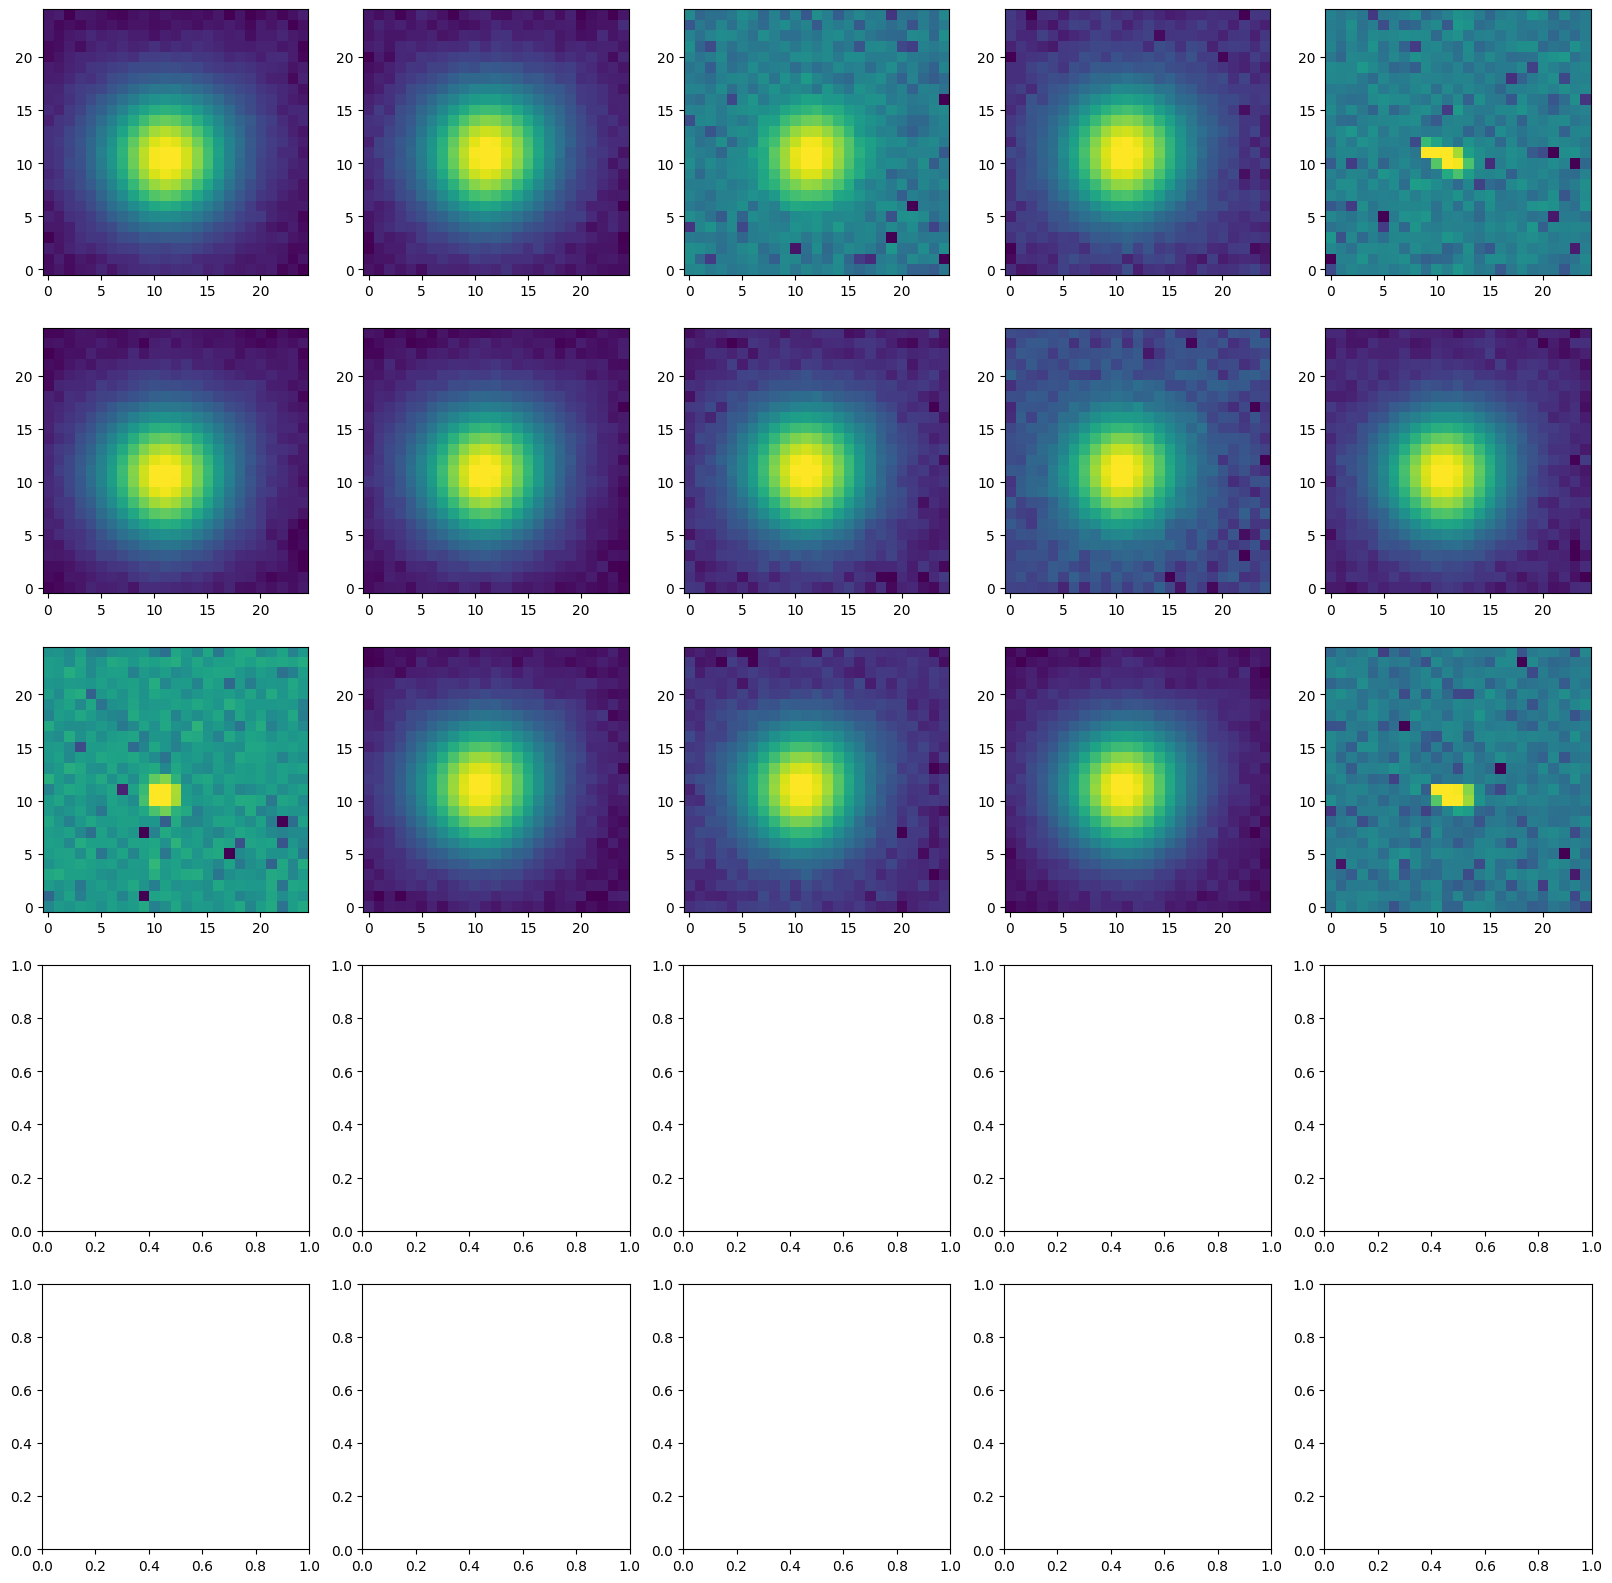

In [13]:
nrows = 5
ncols = 5
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20),
                       squeeze=True)
ax = ax.ravel()
for i in range(nrows * ncols):
    norm = simple_norm(stars[i], 'log', percent=95.0)
    ax[i].imshow(stars[i], norm=norm, origin='lower', cmap='viridis')
# [1,2,10,18,25,28,49,64,88,91,96,135,140,142,147,151,152,153,154,172,179,180,183,184,187]

In [33]:
epsf_builder = EPSFBuilder(oversampling=4, maxiters=10,
                           progress_bar=False)  
epsf, fitted_stars = epsf_builder(stars)

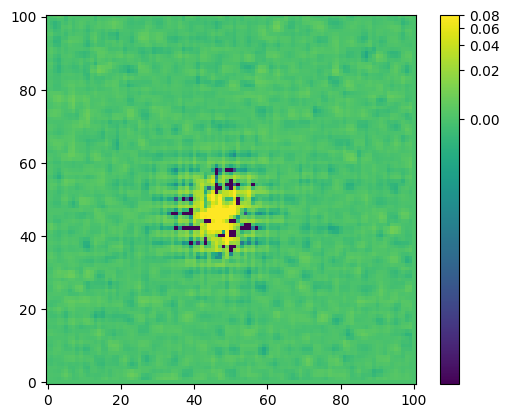

In [34]:
norm = simple_norm(epsf.data, 'log', percent=99.0)
plt.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
plt.colorbar()

In [22]:
epsf.data.shape

(101, 101)

# Testing with simulated data

In [1]:
from photutils.datasets import load_simulated_hst_star_image
hdu = load_simulated_hst_star_image()  
data = hdu.data

In [2]:
from photutils.datasets import make_noise_image
data += make_noise_image(data.shape, distribution='gaussian',
                         mean=10.0, stddev=5.0, seed=123)  

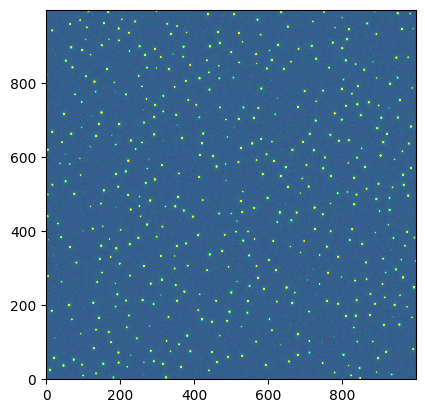

In [3]:
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
from photutils.datasets import (load_simulated_hst_star_image,
                                make_noise_image)

hdu = load_simulated_hst_star_image()
data = hdu.data
data += make_noise_image(data.shape, distribution='gaussian', mean=10.0,
                         stddev=5.0, seed=123)
norm = simple_norm(data, 'sqrt', percent=99.0)
plt.imshow(data, norm=norm, origin='lower', cmap='viridis')

In [4]:
from photutils.detection import find_peaks
peaks_tbl = find_peaks(data, threshold=500.0)  
peaks_tbl['peak_value'].info.format = '%.8g'  # for consistent table output  
print(peaks_tbl)

x_peak y_peak peak_value
------ ------ ----------
   849      2  1076.7026
   182      4  1709.5671
   324      4  3006.0086
   100      9  1142.9915
   824      9  1302.8604
   934     12  891.53049
   135     15  1491.0008
   780     17  965.01121
   893     18  593.88605
   440     23  1235.3081
   ...    ...        ...
   437    985  1980.3149
   508    985  2626.4065
   984    987  738.99136
   950    988  2696.2486
   168    991  1693.8835
   635    991  3607.8909
   751    992  801.23834
   114    994  1595.2804
   299    994  648.18539
   207    998  2810.6503
   691    999  2611.0464
Length = 431 rows


In [5]:
size = 25
hsize = (size - 1) / 2
x = peaks_tbl['x_peak']  
y = peaks_tbl['y_peak']  
mask = ((x > hsize) & (x < (data.shape[1] -1 - hsize)) &
        (y > hsize) & (y < (data.shape[0] -1 - hsize)))

In [6]:
from astropy.table import Table
stars_tbl = Table()
stars_tbl['x'] = x[mask]  
stars_tbl['y'] = y[mask] 

In [7]:
from astropy.stats import sigma_clipped_stats
mean_val, median_val, std_val = sigma_clipped_stats(data, sigma=2.0)  
data -= median_val  

In [8]:
from astropy.nddata import NDData
nddata = NDData(data=data)  

In [9]:
from photutils.psf import extract_stars
stars = extract_stars(nddata, stars_tbl, size=25)

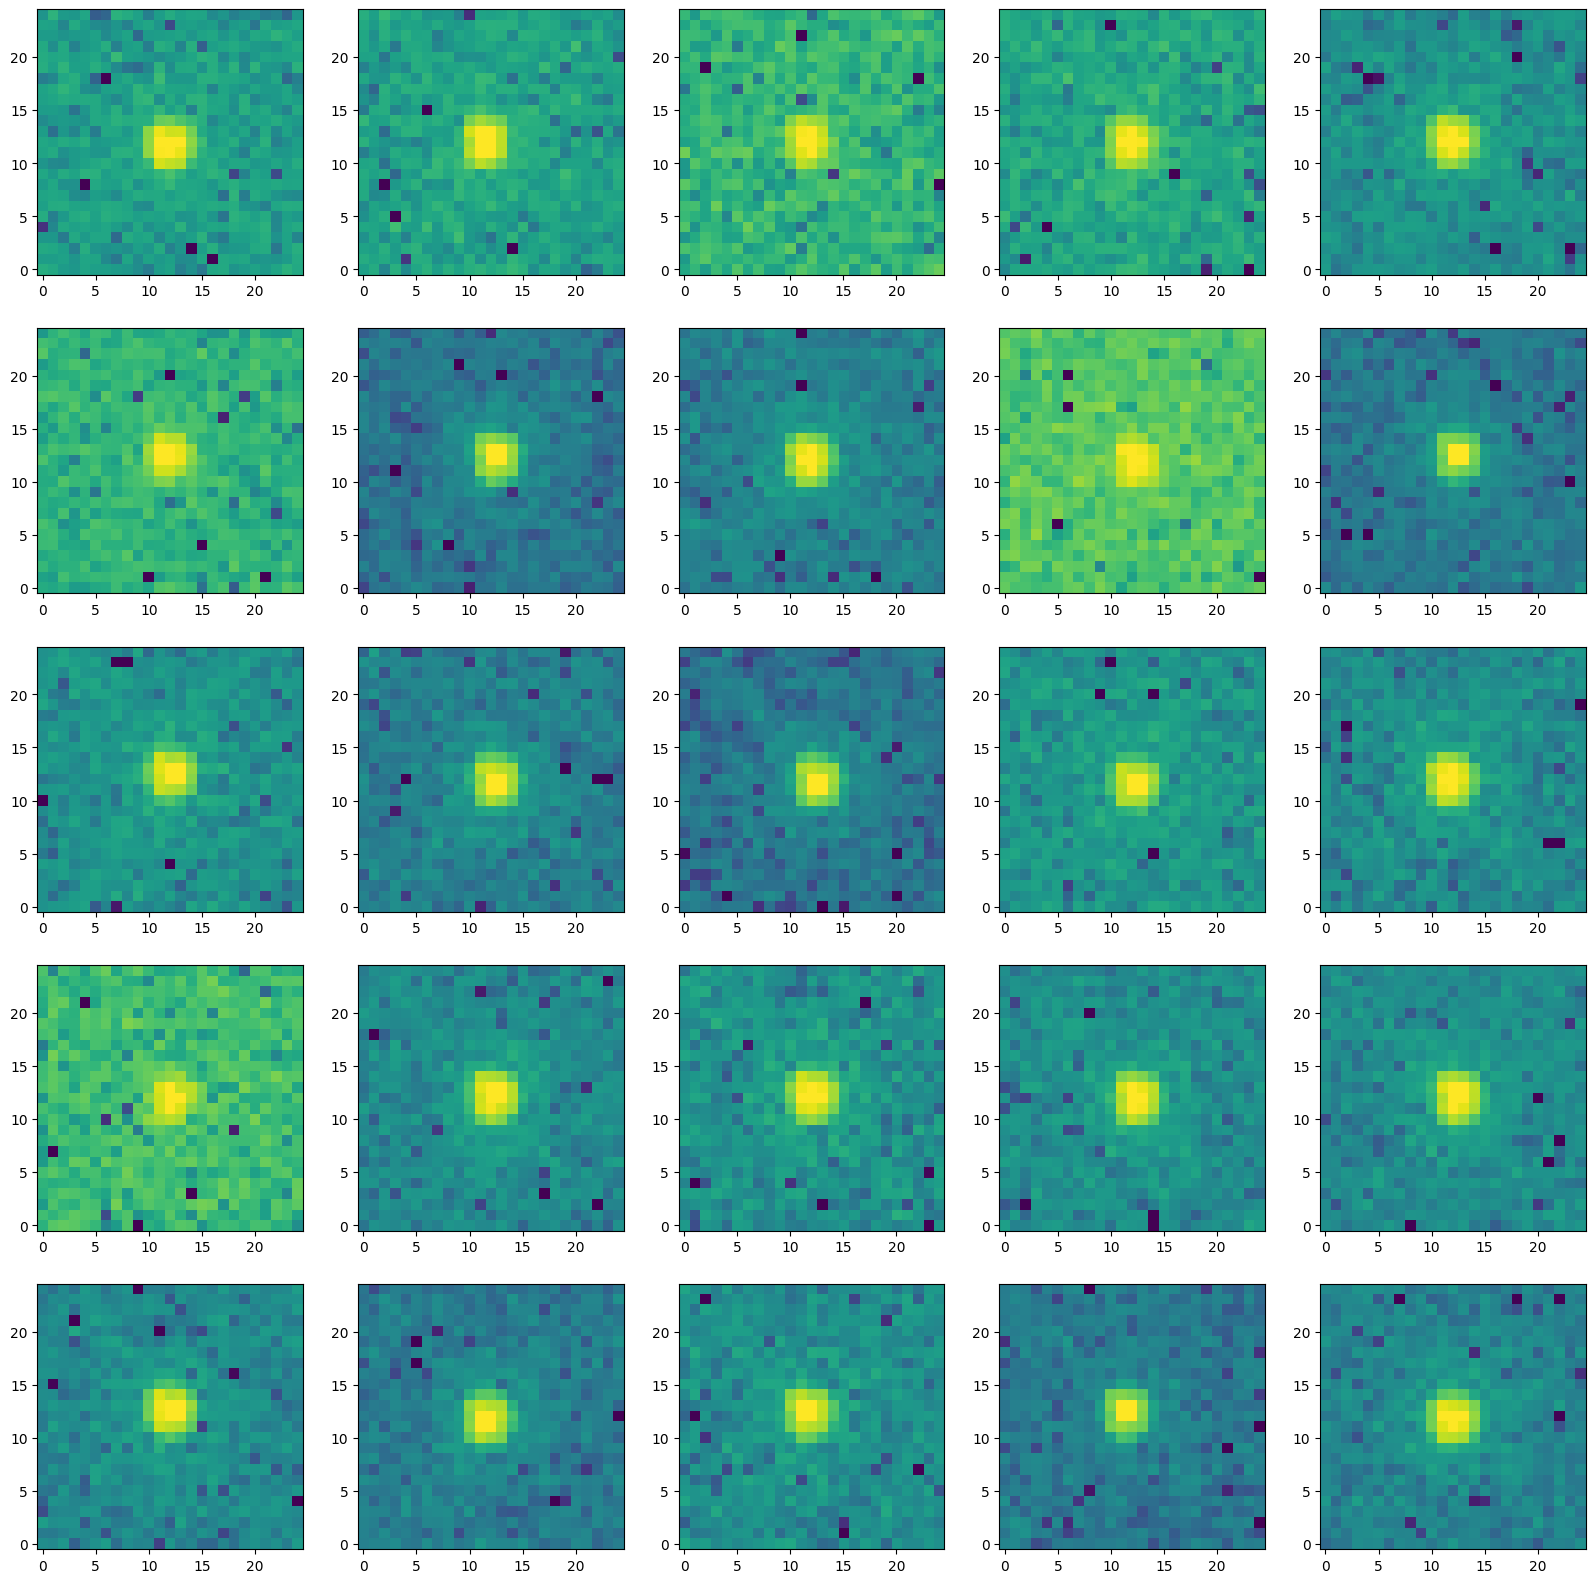

In [10]:
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
nrows = 5
ncols = 5
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20),
                       squeeze=True)
ax = ax.ravel()
for i in range(nrows * ncols):
    norm = simple_norm(stars[i], 'log', percent=99.0)
    ax[i].imshow(stars[i], norm=norm, origin='lower', cmap='viridis')

In [11]:
from photutils.psf import EPSFBuilder
epsf_builder = EPSFBuilder(oversampling=4, maxiters=10,
                           progress_bar=False)  
epsf, fitted_stars = epsf_builder(stars)

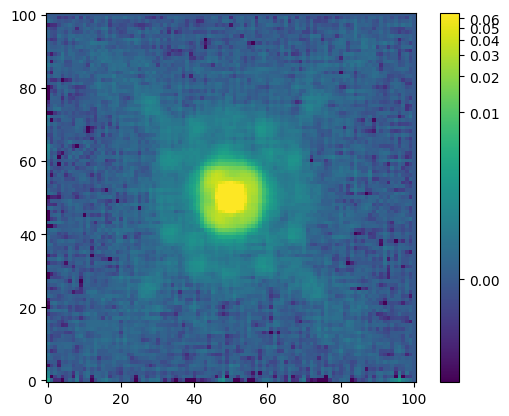

In [12]:
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
norm = simple_norm(epsf.data, 'log', percent=99.0)
plt.imshow(epsf.data, norm=norm, origin='lower', cmap='viridis')
plt.colorbar()

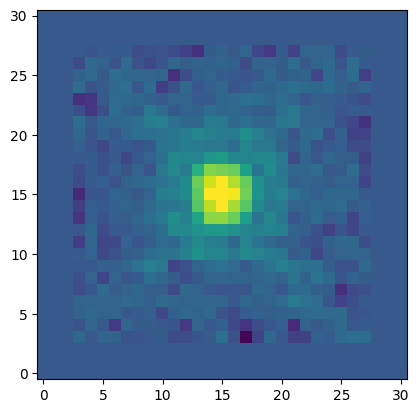

In [13]:
import numpy as np
x, y = np.arange(-15, 16), np.arange(-15, 16)
xv, yv = np.meshgrid(x, y)
test = epsf(xv,yv)
plt.imshow(test, norm=norm, origin='lower', cmap='viridis')

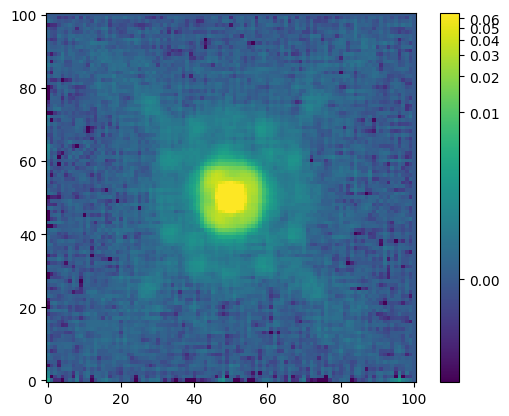

In [14]:
plt.imshow(epsf.normalized_data, norm=norm, origin='lower', cmap='viridis')
plt.colorbar()

In [15]:
epsf._data.shape

(101, 101)

In [16]:
np.sum(epsf.normalized_data), np.sum(test)

(17.051930395579035, 1.0648245724962577)

In [17]:
# plt.imshow(epsf.evaluate(xv, yv, 1,  100, 100), norm=norm, origin='lower', cmap='viridis')

### Testing cat

In [18]:
data_dir = "/global/cscratch1/sd/eramey16/data/curveball/DECam_Reduced/"
cat_file = data_dir+"2022-10-02/c4d_20221002_040110_g_v1.24.cat"
img_file = data_dir+"2022-10-02/c4d_20221002_040110_g_v1.24.fits"
weight_file = data_dir+"2022-10-02/c4d_20221002_040110_g_v1.24.weight.fits"
mask_file = data_dir+"2022-10-02/c4d_20221002_040110_g_v1.24.mask.fits"

In [15]:
import processing
import mystuff

In [17]:
decam = mystuff.init(["DECam", "Reduced"])

In [20]:
processing.extract_catalog(decam, img_file, weight_file, cat_file)

[2023-03-10 16:59:48,487 - INFO] - Running sextractor on c4d_20221002_040110_g_v1.24.fits, extracting to c4d_20221002_040110_g_v1.24.cat
[2023-03-10 16:59:48,505 - INFO] - -PHOT_APERTURES 5.975970511436464,22.198998928070072
[2023-03-10 16:59:48,506 - DEBUG] - Executing command: source-extractor -CATALOG_TYPE FITS_LDAC -CATALOG_NAME /global/cscratch1/sd/eramey16/data/curveball/DECam_Reduced/2022-10-02/c4d_20221002_040110_g_v1.24.cat -BACK_TYPE AUTO -BACK_SIZE 256  -CHECKIMAGE_TYPE NONE -GAIN_KEY GAINA -SATUR_KEY SATURATA -SEEING_FWHM 1.167667343616486 -PIXEL_SCALE 0.263 -MAG_ZEROPOINT 0.0 -MEMORY_OBJSTACK 12000 -MEMORY_PIXSTACK 1200000 -VERBOSE_TYPE QUIET -PHOT_APERTURES 5.975970511436464,22.198998928070072 -FILTER_NAME /usr/share/source-extractor/default.conv -STARNNW_NAME /usr/share/source-extractor/default.nnw -PARAMETERS_NAME /home/curveball/bin/../configdata/sex_scamp.param /global/cscratch1/sd/eramey16/data/curveball/DECam_Reduced/2022-10-02/c4d_20221002_040110_g_v1.24.fits

> WA

CompletedProcess(args='source-extractor -CATALOG_TYPE FITS_LDAC -CATALOG_NAME /global/cscratch1/sd/eramey16/data/curveball/DECam_Reduced/2022-10-02/c4d_20221002_040110_g_v1.24.cat -BACK_TYPE AUTO -BACK_SIZE 256  -CHECKIMAGE_TYPE NONE -GAIN_KEY GAINA -SATUR_KEY SATURATA -SEEING_FWHM 1.167667343616486 -PIXEL_SCALE 0.263 -MAG_ZEROPOINT 0.0 -MEMORY_OBJSTACK 12000 -MEMORY_PIXSTACK 1200000 -VERBOSE_TYPE QUIET -PHOT_APERTURES 5.975970511436464,22.198998928070072 -FILTER_NAME /usr/share/source-extractor/default.conv -STARNNW_NAME /usr/share/source-extractor/default.nnw -PARAMETERS_NAME /home/curveball/bin/../configdata/sex_scamp.param /global/cscratch1/sd/eramey16/data/curveball/DECam_Reduced/2022-10-02/c4d_20221002_040110_g_v1.24.fits', returncode=1)

### Code from testpsfs.py

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from astropsf import AstroPSF
%matplotlib inline

In [2]:
file = '/pscratch/sd/e/eramey16/data/curveball/DECam_Reduced/2022-10-11/c4d_20221011_043436_i_v1.24.psf'
imgfile = file.split('.')
imgfile[-1] = 'fits'
imgfile = '.'.join(imgfile)
psf = AstroPSF(file, imgfile)

29


In [10]:
test1 = psf.generate_psf(1000, 1000)
test2 = psf.generate_psf(50, 50)
# There are residuals!

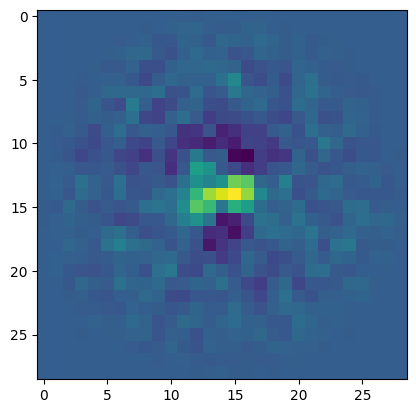

In [11]:
psfdata = test1-test2
plt.imshow(psfdata)

# AstroPSF object

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pathlib
import os
import ldac
from astropsf import AstroPSF
from photutils.psf import FittableImageModel, EPSFModel
from astropy.modeling import Fittable2DModel
from astropy.visualization import simple_norm
from photutils.psf import prepare_psf_model, DAOPhotPSFPhotometry, EPSFFitter
from photutils.background import MMMBackground
from astropy.stats import SigmaClip
from astropy.io import fits
from astropy.table import Table
from astropy.nddata import NDData
%matplotlib inline

In [2]:
# file = '$SCRATCH/data/curveball/DECam_Reduced/2022-10-11/c4d_20221011_043436_i_v1.24.psf'
# file = '$SCRATCH/data/curveball/ZTF/2018-06-05/ztf_20180605309225_000721_zr_io.053.psf'
file = '$SCRATCH/data/curveball/DECam_Reduced/2022-10-02/c4d_20221002_040110_g_v1.24.psf'
psffile = pathlib.Path(os.path.expandvars(file))
imgfile = psffile.with_suffix('.fits')
cat_file = psffile.with_suffix('.cat')

0.25


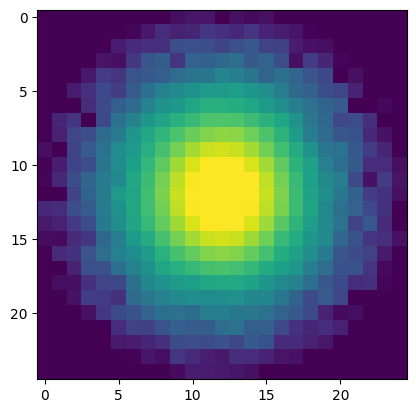

In [3]:
psf = AstroPSF(psffile)
psfdata, psfbase = psf.generate_psf(100, 100)
norm = simple_norm(psfdata.data, 'log', percent=95.0)
plt.imshow(psfdata.data, norm=norm)

In [4]:
tbl = ldac.get_table_from_ldac( cat_file )
# Get coords of things we are mostly sure are stars
tbl = tbl[tbl['CLASS_STAR'] > 0.95]
print(len(tbl))
tbl[50:60]

82


<Table length=10>
  NUMBER   ID_PARENT  MAG_AUTO ... CLASS_STAR            VIGNET           
                        mag    ...                         ct             
  int32      int32    float32  ...  float32          float32[35,35]       
---------- ---------- -------- ... ---------- ----------------------------
       387        398 -10.4427 ...      0.980     1.612839 ..    -1.286423
       408        420 -10.4887 ...      0.982     8.293854 ..   -0.7097015
       411        445 -16.2139 ...      1.000     6.013702 ..     9.685684
       414        423  -9.0990 ...      0.997    -5.516434 ..     11.95575
       423        432  -8.8875 ...      0.976     1.542084 ..    -7.985886
       433        440  -8.8165 ...      0.952     11.50626 ..     7.064774
       454        472 -13.7597 ...      0.996   0.03894043 ..    -3.091949
       459        479 -13.3420 ...      0.985     2.883667 ..  -0.06817627
       467        485  -9.8427 ...      0.979     -4.61731 ..    -2.957108
       472        486  -9.9942 ...      0.974    0.6972046 ..     8.647583

In [5]:
with fits.open(imgfile) as file:
    imghdr = file[0].header
    imgdata = file[0].data

In [6]:
imghdr['SEEING']

1.170783987522125

In [7]:
stars_tbl = Table()
stars_tbl['x'] = tbl['X_IMAGE']
stars_tbl['y'] = tbl['Y_IMAGE']
from photutils.psf import extract_stars
nddata = NDData(imgdata)
stars = extract_stars(nddata, stars_tbl, size=25)
len(stars)

82

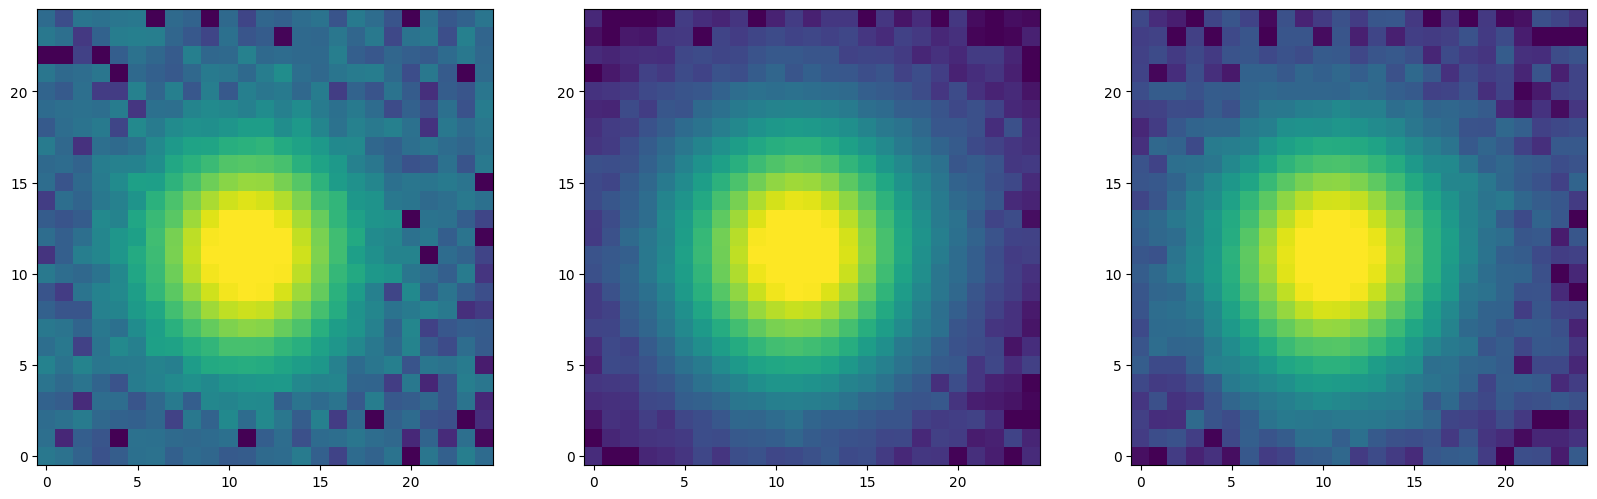

In [8]:
nrows = 1
ncols = 3
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(20, 20),
                       squeeze=True)
ax = ax.ravel()
# idxs = [84,85,90]
# idxs = np.arange(nrows*ncols)
idxs = [8,10,17]
for i in range(nrows * ncols):
    norm = simple_norm(stars[idxs[i]], 'log', percent=95.0)
    ax[i].imshow(stars[idxs[i]], norm=norm, origin='lower', cmap='viridis')
    # ax[i].annotate(str(i), xy=(10,10), color='w', size=16)
# stars.center_flat[idxs]

array([1661.56469727,  904.95178223])

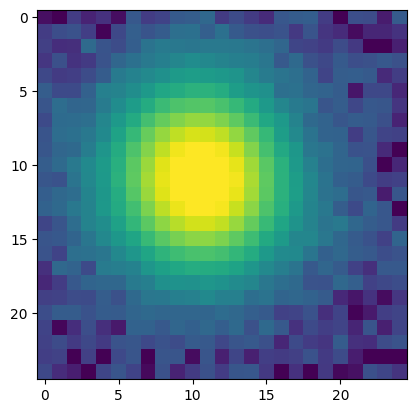

In [9]:
plt.imshow(stars[17].data, norm=norm)
stars[17].center

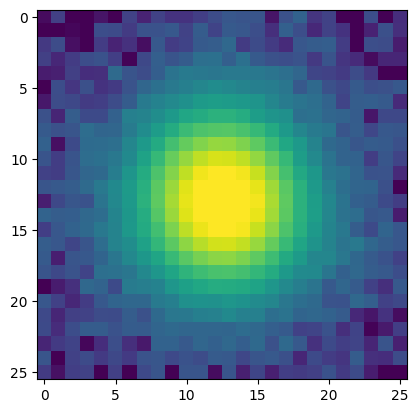

In [10]:
idx = idxs[-1]
sn_x, sn_y = np.ravel(stars[idx].center_flat)
plt.imshow(imgdata[int(sn_y-13):int(sn_y+13), int(sn_x-13):int(sn_x+13)], norm=norm)
# x and y are reversed, and image is flipped vertically compared to extract_stars version

In [15]:
psf = AstroPSF(psffile)
psfdata = psf.generate_psf(sn_x, sn_y)

0.53748333


1.0038072916699696

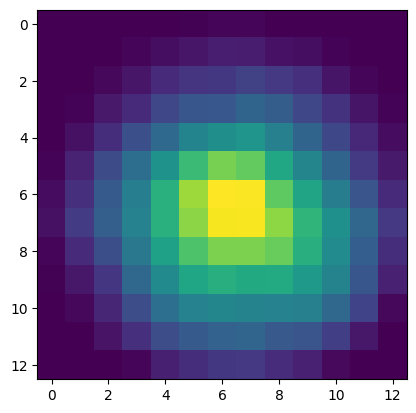

In [16]:
from astropy.visualization import simple_norm
norm = simple_norm(psfdata.data, 'log', percent=99.0)
plt.imshow(psfdata.data, norm=norm)
np.sum(psfdata.data)

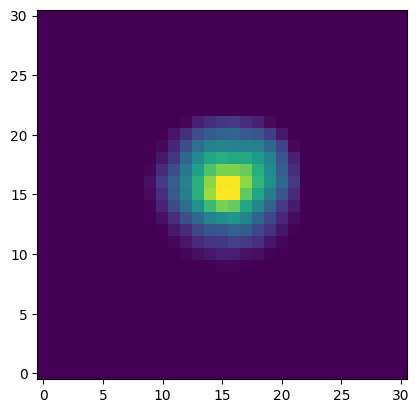

In [17]:
import numpy as np
x, y = np.arange(-15, 16), np.arange(-15, 16)
xv, yv = np.meshgrid(x, y)
test = psfdata(xv,yv)
plt.imshow(test, norm=norm, origin='lower', cmap='viridis')

### EPSFFitter object

In [18]:
from astropy.wcs import WCS
wcs = WCS(imghdr)

In [19]:
from photutils.psf import EPSFStar, EPSFStars
epsfstar = EPSFStar(stars[idx].data, origin=stars[idx].origin, 
                    cutout_center=stars[idx].cutout_center, wcs_large=wcs)
epsfstars = EPSFStars([epsfstar])

In [20]:
psfdata.x_0.fixed = True
psfdata.y_0.fixed = True

In [21]:
# IMPORTANT this forces it to do photometry at the input center
fitter = EPSFFitter()
fitted_stars = fitter(psfdata, epsfstars)

In [22]:
fitted_stars.flux, fitted_stars.center, epsfstar.center

(52468.426519837,
 array([2554.49023438,  481.4130249 ]),
 array([2554.49023438,  481.4130249 ]))

### Previous stuff

In [7]:
sigma_clip = SigmaClip(sigma=3.0)
bkg = MMMBackground(sigma_clip=sigma_clip)

In [8]:
dao = DAOPhotPSFPhotometry(crit_separation=8, threshold=2.5*bkg(imgdata), 
                           fwhm=4.5, psf_model=psfdata, aperture_radius=6.5,
                           fitshape=psfdata.data.shape)

In [9]:
phot_results = dao(imgdata)

In [10]:
phot_results['id', 'group_id', 'iter_detected', 'x_0', 'y_0', 'flux_0']
len(phot_results)

1204

In [11]:
dao.fitter.fit_info['message']

'The relative error between two consecutive iterates is at most 0.000000'

In [12]:
phot_results.columns

<TableColumns names=('x_0','x_fit','y_0','y_fit','flux_0','flux_fit','id','group_id','flux_unc','x_0_unc','y_0_unc','iter_detected')>

# Rob's PSF reader code

In [1]:
from astropy.io import fits
import pathlib
import numpy as np
import os
import matplotlib.pyplot as plt
from photutils.psf import EPSFModel, EPSFFitter, EPSFStar, EPSFStars
from psfexreader import PSFExReader

file = '$SCRATCH/data/curveball/DECam_Reduced/2022-10-02/c4d_20221002_040110_g_v1.24.psf'
psffile = pathlib.Path(os.path.expandvars(file))
imgfile = psffile.with_suffix('.fits')
cat_file = psffile.with_suffix('.cat')
weightfile = psffile.with_suffix('.weight.fits')

In [2]:
with fits.open(imgfile) as file:
    maskedimage = file[0].data
    hdr = file[0].header
with fits.open(weightfile) as file:
    weight = file[0].data
# noise = 1/np.sqrt(weight)

1660.56469727 903.95178223


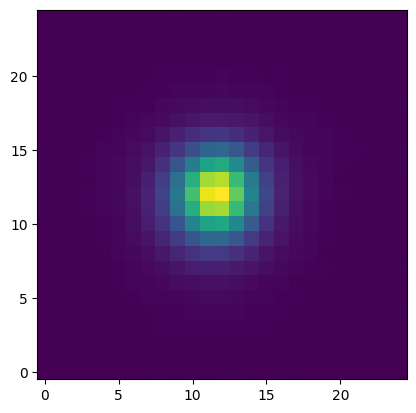

In [3]:
snx, sny = 1661.56469727-1,  904.95178223-1
print(snx, sny)
x, y = int(snx+.5), int(sny+.5)

clip = maskedimage[y-12:y+13, x-12:x+13]
clipwt = weight[y-12:y+13, x-12:x+13]
plt.imshow(clip, origin='lower')

In [4]:
cutout_center = [snx-x+12, sny-y+12]
origin = [x-12, y-12]
star = EPSFStar(clip, weights=np.sqrt(clipwt), cutout_center=cutout_center, origin=origin)

In [5]:
# plt.imshow(clipwt)
# from astropy.io import fits
# fits.writeto("testweight.fits", clipwt)
# fits.writeto("teststar.fits", clip)

In [6]:
reader = PSFExReader(psffile)
psfdata = reader.get_resampled_psf(snx, sny)

15.816051

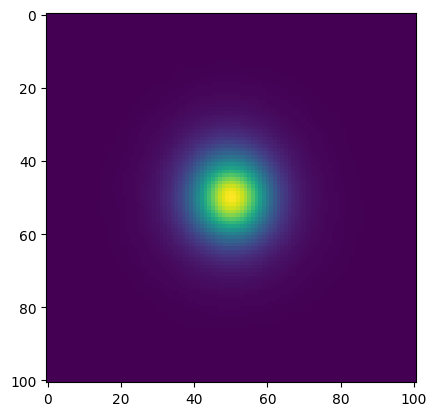

In [7]:
plt.imshow(psfdata)
np.sum(psfdata)

In [8]:
norm_radius = 25 / (2*np.sqrt(2))
flux = np.sum(psfdata)
psfmodel = EPSFModel(psfdata, x_0=snx, y_0=sny, flux=flux, oversampling=4, normalize=False)
# psfmodel.x_0.fixed = True
# psfmodel.y_0.fixed = True

In [9]:
psfmodel

<EPSFModel(flux=15.81605053, x_0=1660.56469727, y_0=903.95178223)>

In [10]:
print(psfmodel.oversampling)

[4 4]


In [11]:
fitter = EPSFFitter()
fitted = fitter(psfmodel, EPSFStars(star))

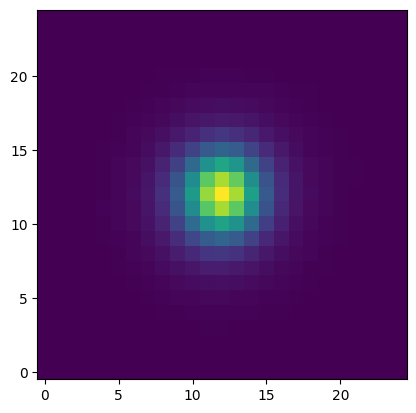

In [12]:
xx, yy = np.arange(x-12, x+13), np.arange(y-12, y+13)
xv, yv = np.meshgrid(xx, yy)
test = psfmodel.evaluate(xv,yv,flux=1, x_0=x, y_0=y)
plt.imshow(test, origin='lower', cmap='viridis')

In [13]:
np.sum(test)

0.9884962852082708

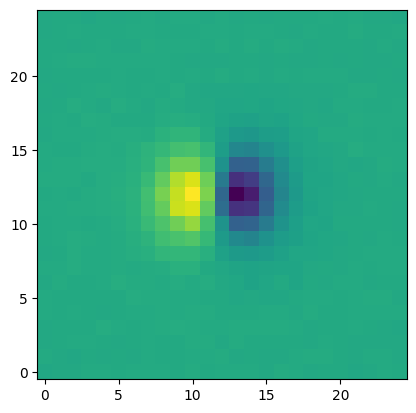

In [20]:
resid = clip - test
plt.imshow(resid, origin='lower', cmap='viridis')

In [25]:
fitted.flux

164498.61969205888

In [26]:
fitted.center

array([1660.58066773,  903.99813706])

In [27]:
fitted.center

array([1660.58066773,  903.99813706])

In [28]:
np.sqrt(fitter.fitter.fit_info.get('param_cov')[0,0])

1457.6179043445925

-0.038154602

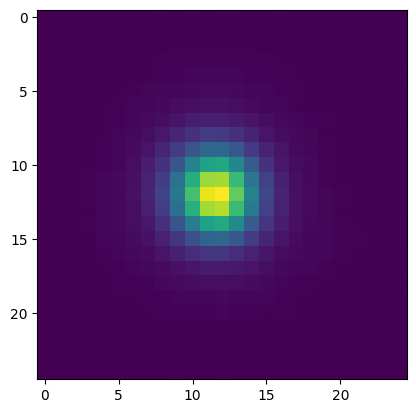

In [13]:
plt.imshow(star)
np.mean([clip[0,0], clip[0,-1], clip[-1,-1], clip[-1,0]])

In [10]:
star.center

array([1660.56469727,  903.95178223])

In [11]:
psfmodel.origin

(1649, 892)

# Fake injection

In [1]:
import sys
import config
import logging
import numpy as np
from exposuresource import ExposureSource
from injectfakes import FakeInjector
import matplotlib.pyplot as plt

In [2]:
logger = logging.getLogger("main")
logger.propagate = False
# logout = logging.StreamHandler( sys.stderr )
# logger.addHandler( logout )
# logout.setFormatter( logging.Formatter( f'[%(asctime)s - %(levelname)s] - %(message)s' ) )
# logger.setLevel( logging.DEBUG )

config.Config.init( 'emily_saul.yaml' , logger=logger )
decam = ExposureSource.get("DECam", "Reduced")

In [3]:
file1 = 'c4d_20221002_040110_g_v1.24'
file2 = 'c4d_20211107_045910_g_v1.24'
file3 = 'c4d_20210929_050208_r_v1.24'
stack1 = 'stack_c4d_20221002_040110_g_v1.24'
stack2 = 'stack_c4d_20221002_040239_r_v1.24'

In [4]:
fakeinj = FakeInjector(decam, file2, stack1)

In [5]:
from emily_muckabout import mystuff
import numpy as np
from injectfakes import FakeInjector
file2 = 'c4d_20211107_045910_g_v1.24'
stack1 = 'stack_c4d_20221002_040110_g_v1.24'
decam = mystuff.init(["DECam", "Reduced"])
fakeinj = FakeInjector(decam, file2, stack1)
rng = np.random.default_rng(42)
df1 = fakeinj.repeatedtrials(11, npsfs=1000, photalg='psfphot1', rng=rng)
df1.to_csv('psf_repeatedtrials_1000.csv', index=False)

Not uploading subtraction files to archive.
Header dimensions (2046 × 4094) don't match expected (2048 × 4096)

> WARNING: default.sex not found, using internal defaults

Not uploading subtraction files to archive.
Can't find file fake_c4d_20211107_045910_g_v1.24.psf.xml, not reading it
Assuming passed image data is sky subtracted.
/curveball/bin/injectfakes.py:607: RuntimeWarning: divide by zero encountered in divide
  imvar = 1. / hdul[0].data
Can't find file fake_c4d_20211107_045910_g_v1.24.psf.xml, not reading it
Header dimensions (2046 × 4094) don't match expected (2048 × 4096)

> WARNING: default.sex not found, using internal defaults

Not uploading subtraction files to archive.
Can't find file fake_c4d_20211107_045910_g_v1.24.psf.xml, not reading it
Assuming passed image data is sky subtracted.
Header dimensions (2046 × 4094) don't match expected (2048 × 4096)

> WARNING: default.sex not found, using internal defaults

Not uploading subtraction files to archive.
Can't find file 

In [10]:
df1

x            y          flux      meanflux     stdflux  \
0   1432.742399  1278.829030   2481.622370   2401.994816   33.232411   
1    897.945288  1451.429314    872.978568    980.248588   18.724041   
2    792.780763  1180.415257   1514.164010   1504.058229   25.286437   
3   1610.047276  2721.899407   4966.223688   4903.234110   32.870834   
4    938.941677  2328.426456    759.904875    710.708415   14.876244   
5   1367.552460  1928.667868  14957.332917  15007.889695   62.675572   
6   1557.291830  1910.755789  29065.369857  29099.693173  126.615544   
7   1298.633683  2266.354066  21315.929660  21338.093633   59.941265   
8   1144.137851  1244.371701   1158.994297   1182.355088   20.373340   
9    921.489629  2796.402415   3846.321119   3839.904589   36.129560   
10   758.652758  3049.056266  15355.234101  15294.336099  100.653120   
11    63.053290  1787.920992   3211.518660   3287.714792   35.695041   
12  1317.348036  1333.929016  16002.056319  15975.735301   59.845907   
13  1683.370261  1516.662037   1306.649931   1305.298847   20.711865   
14   907.225451  1922.361491   4135.113637   4065.412012   48.614482   
15   439.040241  1672.516267   5581.585064   5449.348617   41.429066   
16   119.287409  1151.985654   8049.628205   7951.203532   29.010105   
17   130.570106  1947.535968   1771.066277   1763.196079   23.068177   
18   600.692828  2709.886211   6097.822506   6166.613549   24.882078   
19  1292.385361  2742.218494  21552.624444  21489.464776  107.856815   

         fluxbar   dfluxbar    avgdflux      bkvar  
0    2401.813844  27.113320   59.983599  19.427035  
1     980.161725  23.561313   51.939863  19.493114  
2    1503.920170  25.117482   55.462936  19.592645  
3    4903.080179  32.618111   72.398491  19.562612  
4     710.649965  23.379800   51.522442  19.635962  
5   15007.681726  48.231319  107.485851  19.546980  
6   29099.205064  63.516378  141.750090  19.696660  
7   21337.947347  55.867505  124.611938  19.456280  
8    1182.261664  24.162517   53.301927  19.521378  
9    3839.718785  31.144677   69.073852  19.713072  
10  15293.806376  48.838317  108.850625  19.423663  
11   3287.512721  29.670360   65.743854  19.875390  
12  15975.549918  48.947964  109.094493  19.498289  
13   1305.194709  24.610989   54.316956  19.557406  
14   4065.074406  31.042475   68.855818  19.306444  
15   5449.148687  33.996905   75.503792  19.556743  
16   7951.131643  37.943567   84.387534  19.337515  
17   1763.099113  26.749041   59.150445  19.707490  
18   6166.560718  35.335100   78.508132  19.835450  
19  21488.984617  56.077692  125.083661  19.461715

In [11]:
psf_delta = df1['flux'] - df1['meanflux']

Text(0.5, 1.0, 'PSF Photometry')

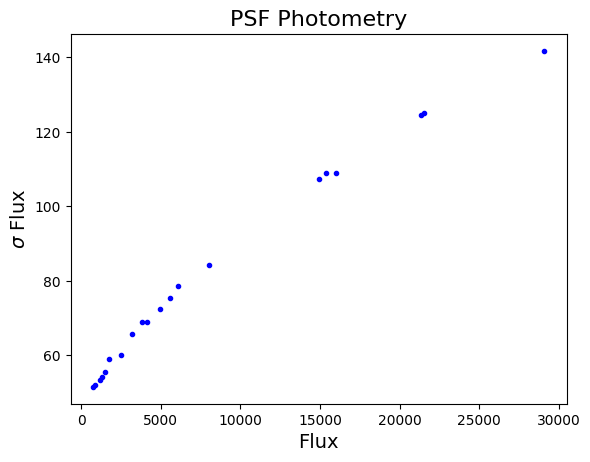

In [16]:
plt.plot(df1.flux, df1.avgdflux, 'b.')
plt.xlabel("Flux", fontsize=14)
plt.ylabel("$\sigma$ Flux", fontsize=14)
plt.title("PSF Photometry", fontsize=16)

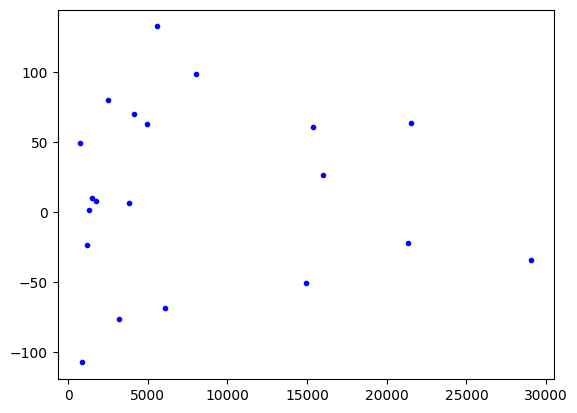

In [18]:
plt.plot(df1.flux, psf_delta, 'b.')

In [13]:
fakeinj.repeatedtrialsstats(df1)

(20,
 4.040805010080812,
 0.9999999971475299,
 -0.38276562636359734,
 -9.718345736296386e-05)

In [14]:
rng = np.random.default_rng(42)
df2 = fakeinj.repeatedtrials(5, npsfs=20, photalg='apphot1', rng=rng)
df2
df2.to_csv('ap_repeatedtrials.csv', index=False)

Not uploading subtraction files to archive.
Header dimensions (2046 × 4094) don't match expected (2048 × 4096)

> WARNING: default.sex not found, using internal defaults

Not uploading subtraction files to archive.
Assuming passed image data is sky subtracted.
Can't find file fake_c4d_20211107_045910_g_v1.24.psf.xml, not reading it
/curveball/bin/injectfakes.py:607: RuntimeWarning: divide by zero encountered in divide
  imvar = 1. / hdul[0].data
Assuming passed image data is sky subtracted.
Can't find file fake_c4d_20211107_045910_g_v1.24.psf.xml, not reading it
Header dimensions (2046 × 4094) don't match expected (2048 × 4096)

> WARNING: default.sex not found, using internal defaults

Not uploading subtraction files to archive.
Assuming passed image data is sky subtracted.
Can't find file fake_c4d_20211107_045910_g_v1.24.psf.xml, not reading it
Header dimensions (2046 × 4094) don't match expected (2048 × 4096)

> WARNING: default.sex not found, using internal defaults

Not uploading 

x            y          flux      meanflux    stdflux  \
0   1432.742399  1278.829030   2481.622370   2464.639318  26.169066   
1    897.945288  1451.429314    872.978568    858.310197  14.045636   
2    792.780763  1180.415257   1514.164010   1484.061602  24.243372   
3   1610.047276  2721.899407   4966.223688   4945.139588  35.572777   
4    938.941677  2328.426456    759.904875    732.462456  21.812244   
5   1367.552460  1928.667868  14957.332917  14990.287634  43.426190   
6   1557.291830  1910.755789  29065.369857  29039.449342  65.657424   
7   1298.633683  2266.354066  21315.929660  21314.742211  68.800871   
8   1144.137851  1244.371701   1158.994297   1120.568989  11.359053   
9    921.489629  2796.402415   3846.321119   3894.914078  31.974584   
10   758.652758  3049.056266  15355.234101  15336.391132  52.809708   
11    63.053290  1787.920992   3211.518660   3360.505707  41.549278   
12  1317.348036  1333.929016  16002.056319  15976.488142  70.433530   
13  1683.370261  1516.662037   1306.649931   1340.954270   6.958962   
14   907.225451  1922.361491   4135.113637   4067.137052  38.888937   
15   439.040241  1672.516267   5581.585064   5554.965318  16.952220   
16   119.287409  1151.985654   8049.628205   8001.702571  34.161183   
17   130.570106  1947.535968   1771.066277   1787.345294  25.938577   
18   600.692828  2709.886211   6097.822506   6161.839065  26.166078   
19  1292.385361  2742.218494  21552.624444  21600.041869  69.724827   

         fluxbar   dfluxbar    avgdflux        bkvar  
0    2464.473580  45.908144   57.597328  1805.097501  
1     858.230283  44.479762   52.042754  1795.956225  
2    1483.873812  45.261124   54.497903  1818.221867  
3    4944.951168  48.413859   65.894635  1844.366447  
4     732.265181  45.051954   52.377378  1851.267520  
5   14990.174096  55.220131   89.248319  1820.271498  
6   29039.308989  64.135614  114.941967  1838.817522  
7   21314.537176  59.378302  101.786512  1817.120083  
8    1120.522436  44.778398   53.109563  1801.228598  
9    3894.729553  47.663840   62.594102  1860.311569  
10  15336.226972  55.675768   90.319306  1835.357007  
11   3360.160956  47.546560   61.264971  1887.523262  
12  15976.206606  55.791168   91.136801  1814.359696  
13   1340.938005  45.210158   54.080663  1823.769866  
14   4066.876429  47.200577   62.690132  1802.375773  
15   5554.925389  48.698756   67.155702  1836.992150  
16   8001.582455  50.433085   73.763882  1819.101837  
17   1787.154638  46.083626   56.289676  1862.509844  
18   6161.751198  49.480070   68.996015  1870.241123  
19  21599.831865  59.713518  102.312933  1840.161664

In [15]:
ap_delta = df2['flux'] - df2['meanflux']

Text(0, 0.5, 'PSF resid - Ap resid')

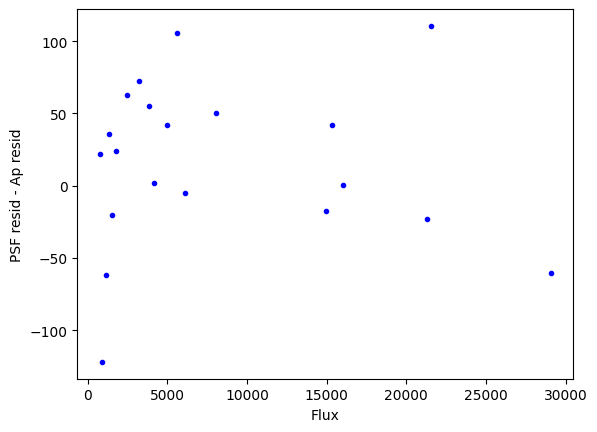

In [20]:
plt.plot(df2['flux'], psf_delta - ap_delta, 'b.')
# plt.plot([50,150], [50, 150], 'k--')
plt.xlabel("Flux")
plt.ylabel("PSF resid - Ap resid")

In [36]:
np.mean(psf_delta), np.mean(ap_delta)

(14.28182819529788, -1.4902665904356411)

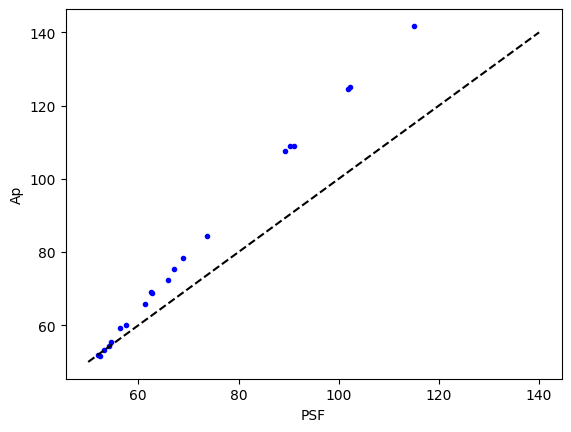

In [34]:
plt.plot(df2.avgdflux, df1.avgdflux, 'b.')
plt.xlabel('PSF')
plt.ylabel('Ap')
plt.plot([50, 140], [50, 140], 'k--')
plt.show()

# Plotting Aperture vs. PSF Photometry

In [1]:
import config
import db
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
config.Config.init('../emily.yaml')

In [20]:


def plot_obj(axes, obj_name, bands=['g', 'r', 'i'], save=False):
    apphots = db.Photometry.get_for_obj(obj_name, version='default_ap')
    psfphots = db.Photometry.get_for_obj(obj_name, version='default_psf')
    
    ap_data = [pd.DataFrame({'mjd': [pt.mjd for pt in apphots[i][1]],
                               'band': apphots[i][0].name,
                               'ap_mag': [pt.mag for pt in apphots[i][1]],
                               'ap_dmag': [pt.dmag for pt in apphots[i][1]],
                               'ap_flux': [pt.flux for pt in apphots[i][1]],
                               'ap_dflux': [pt.dflux for pt in apphots[i][1]],
                               'ap_magzp': [pt.magzp for pt in apphots[i][1]],
                              }, index=[pt.image_id for pt in apphots[i][1]]
                             ) for i in range(len(apphots))
                ]
    psf_data = [pd.DataFrame({'psf_mag': [pt.mag for pt in psfphots[i][1]],
                               'psf_dmag': [pt.dmag for pt in psfphots[i][1]],
                               'psf_flux': [pt.flux for pt in psfphots[i][1]],
                               'psf_dflux': [pt.dflux for pt in psfphots[i][1]],
                               'psf_magzp': [pt.magzp for pt in psfphots[i][1]],
                              }, index=[pt.image_id for pt in psfphots[i][1]]
                             ) for i in range(len(psfphots))
                ]
    all_data = [ap_data[i].merge(psf_data[i], left_index=True, right_index=True)
                for i in range(len(apphots))
               ]
    
    if save:
        save_data = pd.concat(all_data)
        save_data.to_csv(save, index_label='image_id')
    
    for i in range(len(all_data)):
        axes[i].set_title(f'{obj_name} {bands[i].upper()}-band', fontsize=16)

        data = all_data[i]
        lo_mjd, hi_mjd = min(data.mjd), max(data.mjd)
        axes[i].errorbar(data.mjd, data.ap_mag, data.ap_dmag, fmt='r.',
                       ecolor='k', lw=1, label='Ap phot')

        axes[i].errorbar(data.mjd, data.psf_mag, data.psf_dmag, fmt='b.', 
                       ecolor='k', lw=1, label='PSF phot')

        # ax[i].plot([lo_mjd,hi_mjd], [0,0], 'k--')
        # axes[i].set_ylim([15, 20])
        axes[i].invert_yaxis()
        axes[i].set_xlabel("MJD", fontsize=12)
        axes[i].set_ylabel("Magnitude", fontsize=12)

        axes[i].legend()

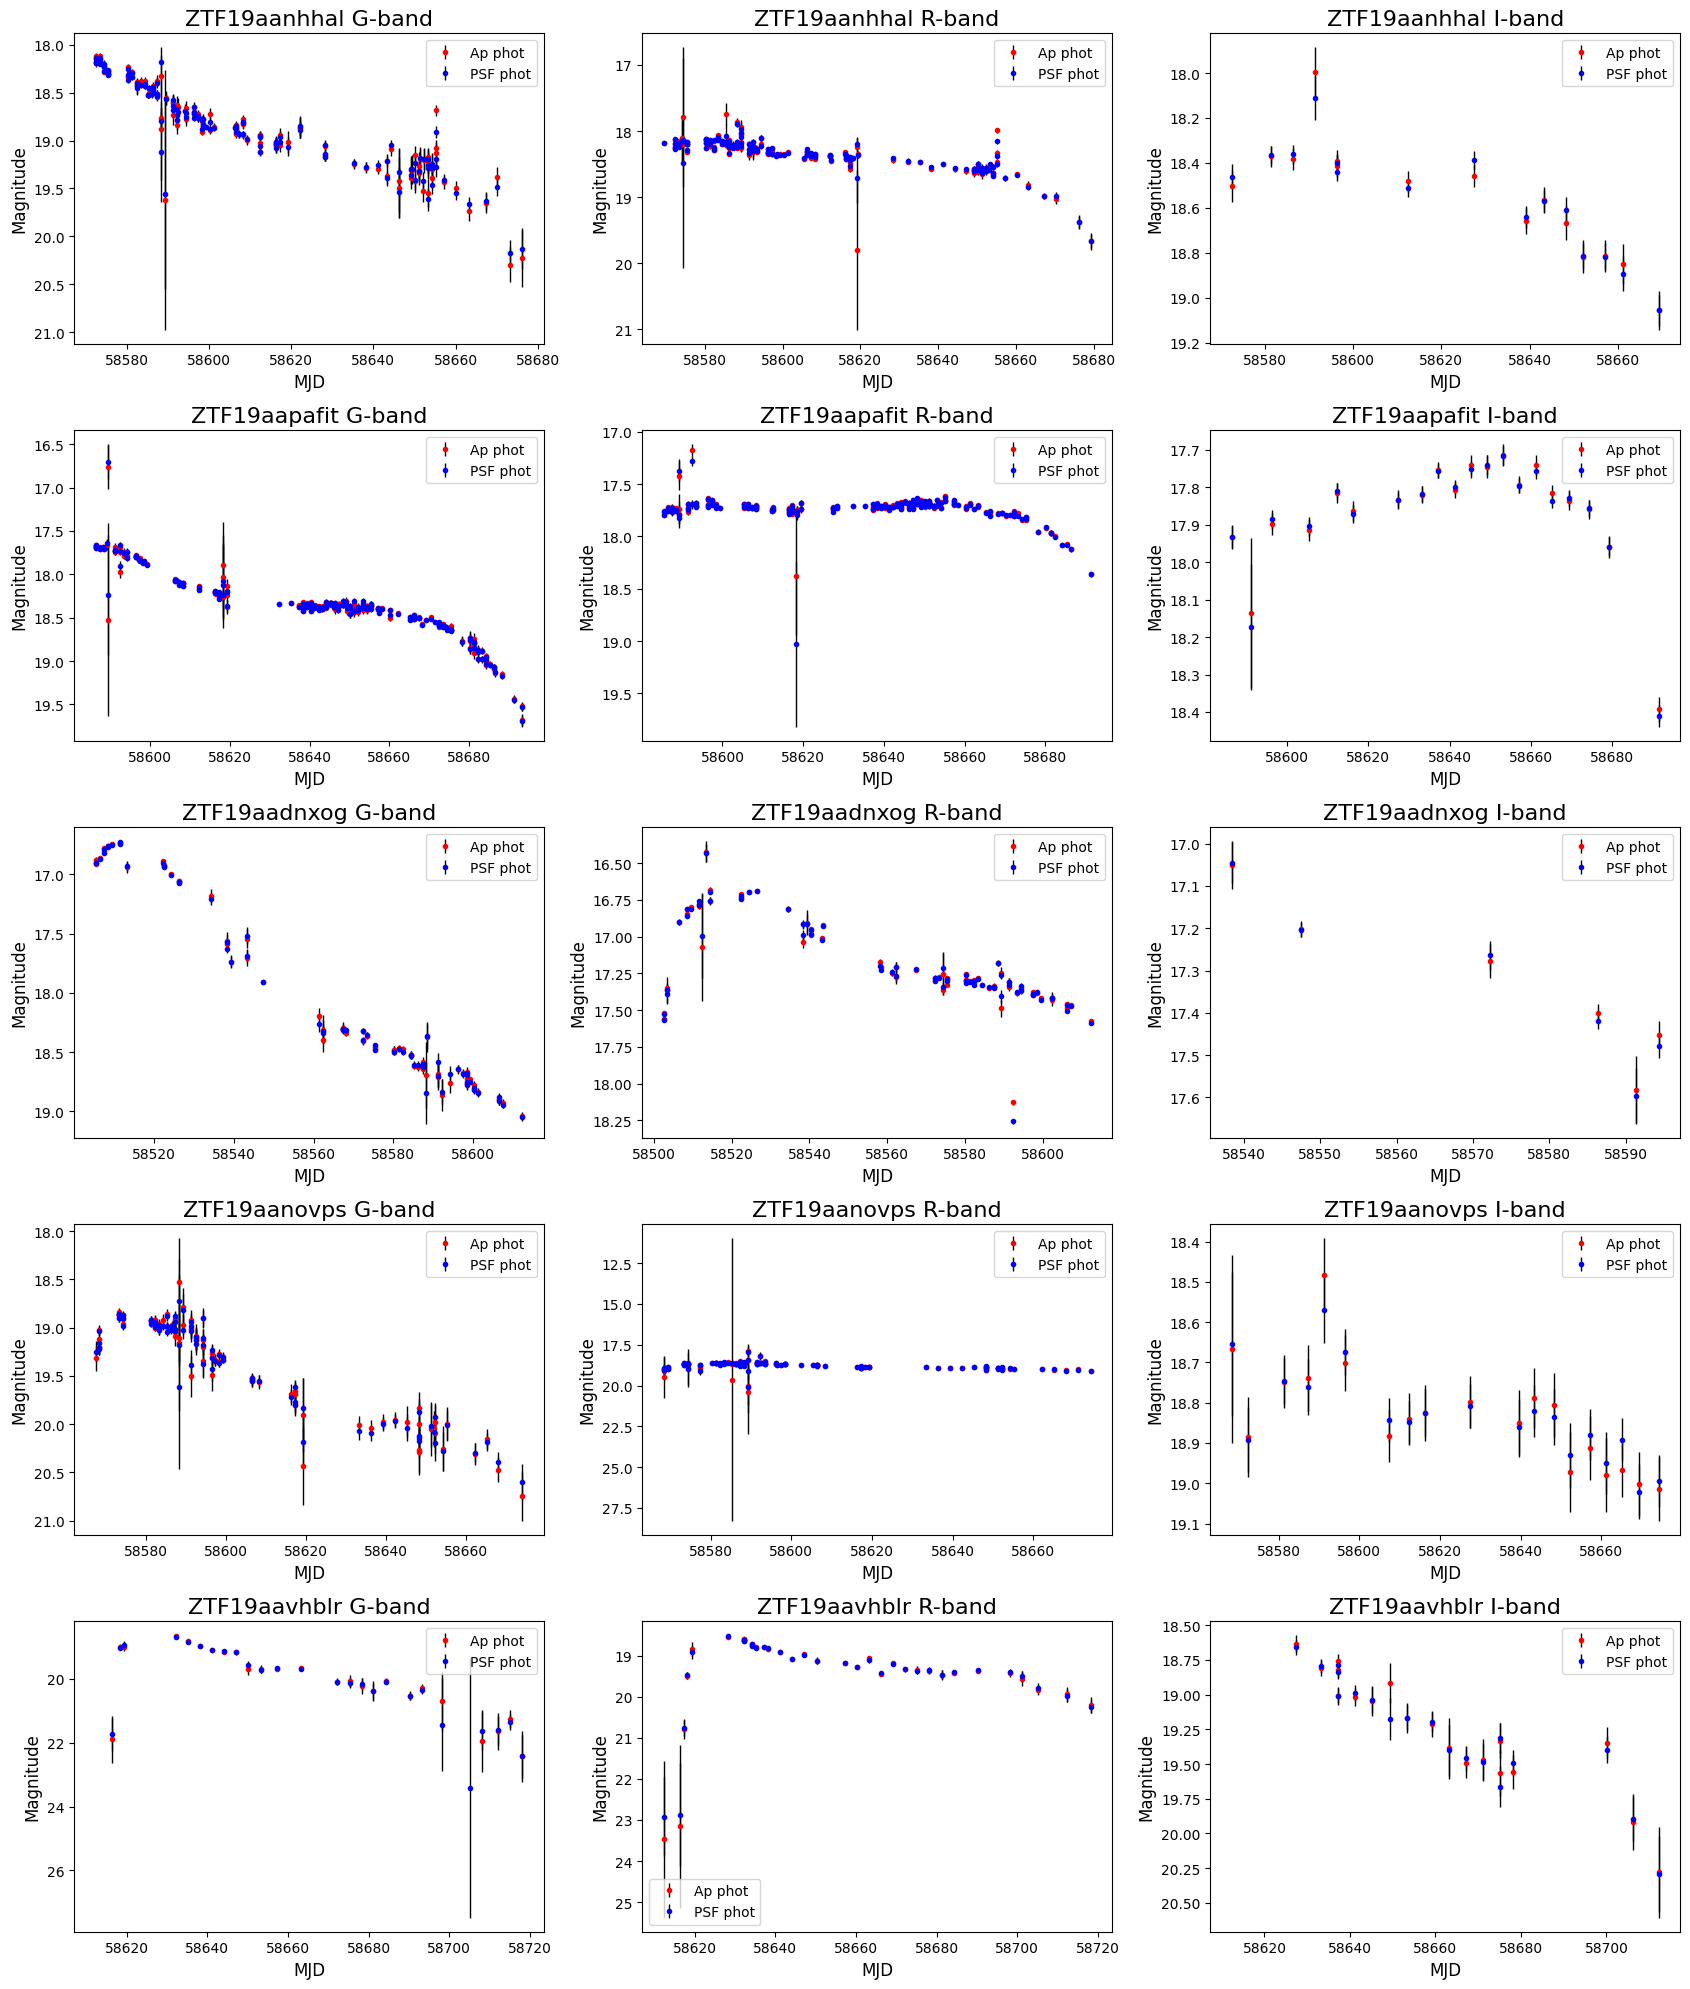

In [22]:
objs = ['ZTF19aanhhal', 'ZTF19aapafit', 'ZTF19aadnxog', 'ZTF19aanovps', 'ZTF19aavhblr']
fig, axes = plt.subplots(len(objs),3, figsize=[17,4*len(objs)])
for i in range(len(objs)):
    ax = axes[i]
    plot_obj(ax, objs[i], save=f'{objs[i]}.csv')
plt.tight_layout()
plt.savefig("figs/ZTF19aa_objects.png", bbox_inches='tight')

In [4]:
# obj = 'DC21cozcn'
obj = 'ZTF19aapafit'
# obj = 'ZTF19abqhobb'
bands = ['g', 'r', 'i']
apphots = db.Photometry.get_for_obj(obj, version='default_ap')
psfphots = db.Photometry.get_for_obj(obj, version='default_psf')

ap_data = [pd.DataFrame({'mjd': [pt.mjd for pt in apphots[i][1]],
                           'ap': [pt.mag for pt in apphots[i][1]],
                           'd_ap': [pt.dmag for pt in apphots[i][1]],
                          }, index=[pt.image_id for pt in apphots[i][1]]
                         ) for i in range(len(apphots))
            ]
psf_data = [pd.DataFrame({'psf': [pt.mag for pt in psfphots[i][1]],
                           'd_psf': [pt.dmag for pt in psfphots[i][1]],
                          }, index=[pt.image_id for pt in psfphots[i][1]]
                         ) for i in range(len(psfphots))
            ]
all_data = [ap_data[i].merge(psf_data[i], left_index=True, right_index=True)
            for i in range(len(apphots))
           ]

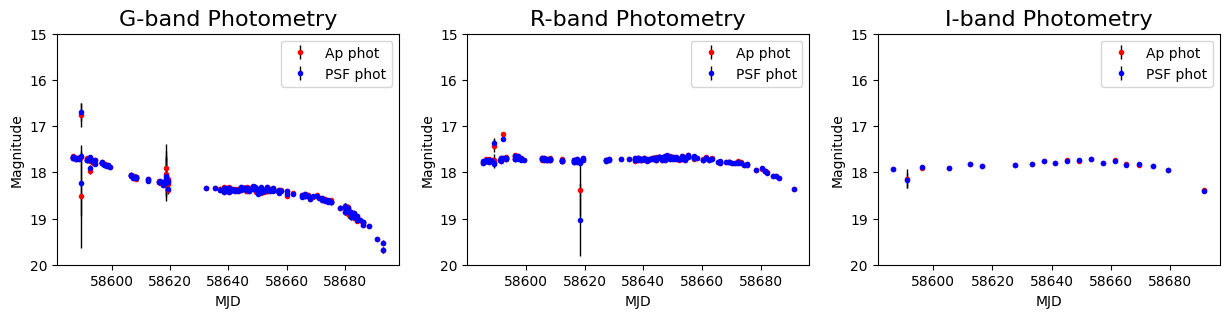

In [5]:
fig, ax = plt.subplots(1,3, figsize=[15,3])
ax = ax.flatten()

for i in range(len(all_data)):
    ax[i].set_title(f'{bands[i].upper()}-band Photometry', fontsize=16)
    
    data = all_data[i]
    lo_mjd, hi_mjd = min(data.mjd), max(data.mjd)
    ax[i].errorbar(data.mjd, data.ap, data.d_ap, fmt='r.',
                   ecolor='k', lw=1, label='Ap phot')
    
    ax[i].errorbar(data.mjd, data.psf, data.d_psf, fmt='b.', 
                   ecolor='k', lw=1, label='PSF phot')
    
    # ax[i].plot([lo_mjd,hi_mjd], [0,0], 'k--')
    ax[i].set_ylim([15, 20])
    ax[i].invert_yaxis()
    ax[i].set_xlabel("MJD")
    ax[i].set_ylabel("Magnitude")
    
    ax[i].legend()
# plt.savefig('figs/compare_phot_DC21coczn.png', bbox_inches='tight')

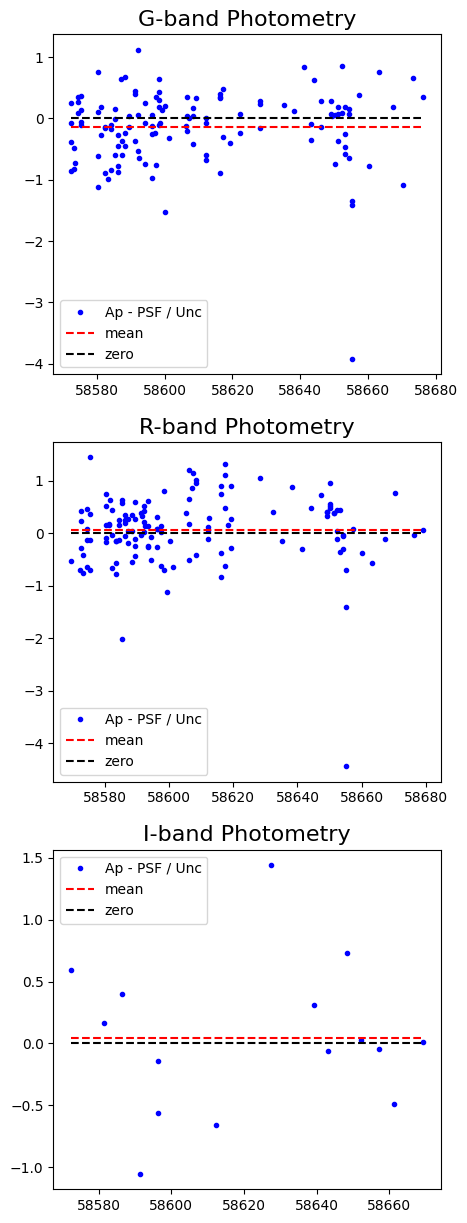

In [4]:
fig, ax = plt.subplots(3,1, figsize=[5,15])
ax = ax.flatten()

for i in range(len(bands)):
    ax[i].set_title(f'{bands[i].upper()}-band Photometry', fontsize=16)
    
    # Get psf and ap photometry
    data = all_data[i]
    
    # Plot subtraction
    sub = (data.ap-data.psf) / data.d_ap
    ax[i].plot(data.mjd, sub, 'b.', label='Ap - PSF / Unc')
    
    # idx = sub.argsort()[-5]
    # print(f"Index: {idx}, {ap[idx]}")
    
    mean = np.mean(sub)
    lo_mjd, hi_mjd = min(data.mjd), max(data.mjd)
    ax[i].plot([lo_mjd,hi_mjd], [mean, mean], 'r--', label='mean')
    ax[i].plot([lo_mjd,hi_mjd], [0,0], 'k--', label='zero')
    
    ax[i].legend()
# plt.savefig('figs/subtract_phot_DC21coczn.png', bbox_inches='tight')

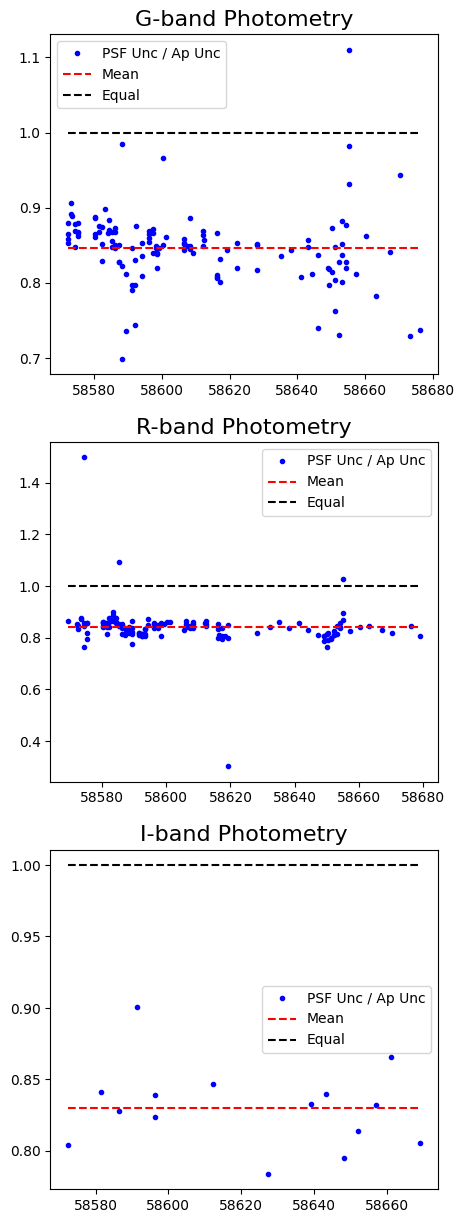

In [5]:
fig, ax = plt.subplots(3,1, figsize=[5,15])
ax = ax.flatten()

for i,band in enumerate(bands):
    ax[i].set_title(f'{bands[i].upper()}-band Photometry', fontsize=16)
    
    # Get psf and ap photometry
    data = all_data[i]
    
    # Plot subtraction
    result = data.d_psf / data.d_ap
    ax[i].plot(data.mjd, result, 'b.', label='PSF Unc / Ap Unc')
    
    mean = np.mean(result)
    lo_mjd, hi_mjd = min(data.mjd), max(data.mjd)
    ax[i].plot([lo_mjd,hi_mjd], [mean, mean], 'r--', label='Mean')
    ax[i].plot([lo_mjd,hi_mjd], [1,1], 'k--', label='Equal')
    
    ax[i].legend()
# plt.savefig('figs/unc_phot_DC21coczn.png', bbox_inches='tight')

In [ ]:
s2 = db.Salt2Fit.get_for_obj(obj)

In [ ]:
### End of graphs, random stuff follows

In [6]:
ap_idx = [x.mjd for x in apphots[1][1]].index(59486.20982277)
psf_idx = [x.mjd for x in psfphots[1][1]].index(59486.20982277)
ap_idx, psf_idx

(30, 30)

In [7]:
ap_pt = apphots[1][1][30]
psf_pt = psfphots[1][1][30]
ap_pt.image_id, psf_pt.image_id

(119, 119)

In [8]:
from db import Image, DB
with DB.get(None) as db:
    q = db.db.query(Image).filter( Image.id==119 )
    them = q.all()
img = them[0]
img.basename

'c4d_20210929_050208_r_v1.24'

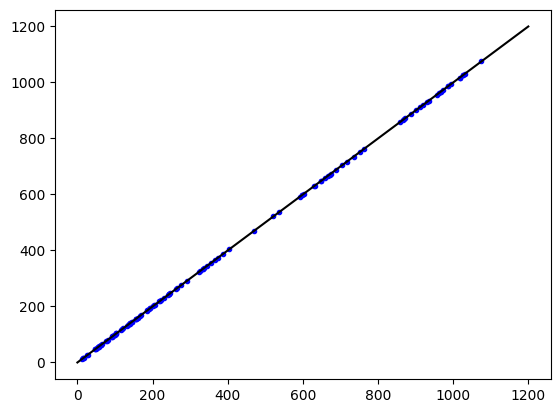

In [33]:
mags = np.array([(x.flux, x.mag, x.magzp) for x in psfphots[0][1]])
adus = 10**((mags[:,1]-mags[:,2])/(-2.5))
plt.plot(mags[:,0], adus, 'b.')
plt.plot([0,1200], [0,1200], 'k')
# This is the correct equation for mag -> ADU

# SNcosmo tests

In [1]:
import sncosmo

In [11]:
model = sncosmo.Model(source='hsiao')
model.set(z=0.5, t0=55000., amplitude=1.e-10)
# model.set_source_peakabsmag(1.e-10)

In [12]:
model.bandmag('desg', 'ab', [54990., 55000., 55020.])

array([25.49791351, 25.38599507, 27.04211283])

# InjectFakes large runs

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm

In [87]:
def plot_injectfakes(fake_file, xrange=None):
    fakes = pd.read_csv(fake_file)
    fakes = fakes[fakes.flux_ap < 50000]
    ap_data = (fakes.flux_ap - fakes.meanflux_ap)
    psf_data = (fakes.flux_psf - fakes.meanflux_psf)
    
    if xrange is None:
        all_data = pd.concat([ap_data, psf_data])
        xrange = [np.min(all_data), np.max(all_data)]
    
    n_ap, _, _ = plt.hist(ap_data, bins=50, histtype='step', color='r',
             label='apphot1', range=xrange)
    n_psf, _, _ = plt.hist(psf_data, bins=50, histtype='step', color='b',
             label='psfphot1', range=xrange)
    
    ap_middle = ap_data[(ap_data < xrange[1]) & (ap_data > xrange[0])]
    psf_middle = psf_data[(psf_data < xrange[1]) & (psf_data > xrange[0])]
    
    mean_ap, std_ap = ap_middle.mean(), ap_middle.std()
    mean_psf, std_psf = psf_middle.mean(), psf_middle.std()
    
    x = np.arange(xrange[0], xrange[1])
    plt.plot(x, norm(mean_ap, std_ap).pdf(x), 'r--', label=f"Ap Mean = {mean_ap:.2f}")
    plt.plot(x, norm(mean_psf, std_psf).pdf(x), 'b--', label=f"PSF Mean = {mean_psf:.2f}")
    plt.legend()

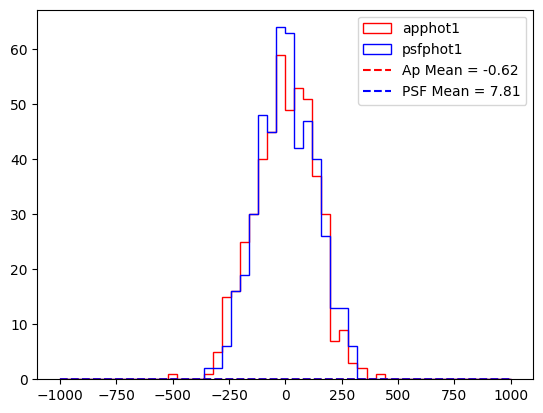

In [89]:
plot_injectfakes('fakes_single_20runs.csv', xrange=[-1000, 1000])

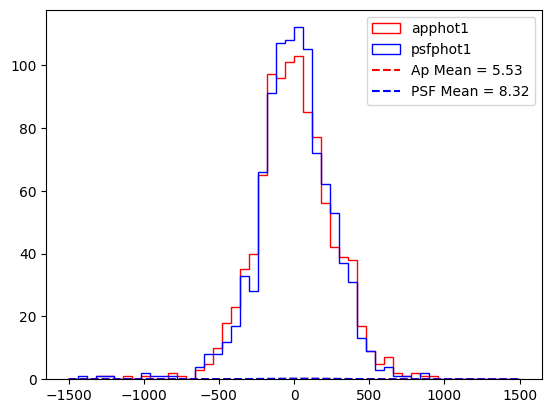

In [60]:
plot_injectfakes('fakes_multiimg.csv', xrange=[-1500, 1500])

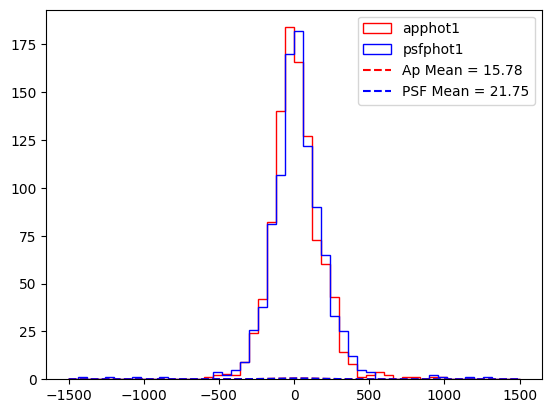

In [63]:
plot_injectfakes('fakes_multiref.csv', xrange=[-1500, 1500])

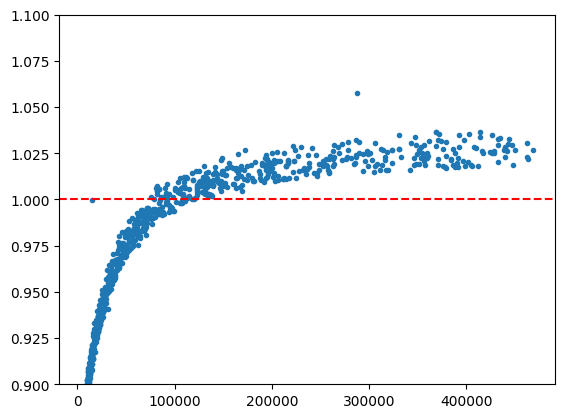

In [81]:
data = pd.read_csv('fakes_single_20runs.csv')
plt.plot(data.flux_ap, (data.avgdflux_psf / data.avgdflux_ap), '.')
plt.ylim([.9, 1.1])
plt.axhline(1.0, color='r', linestyle='--')

In [82]:
data.img[0]

'c4d_20211224_022754_i_v1.24'

In [11]:
# ap_data = pd.read_csv("ap_repeatedtrials_1000.csv")
# psf_data = pd.read_csv("psf_repeatedtrials_1000.csv")
# merged = ap_data.merge(psf_data, on=['x', 'y'], suffixes=['_ap', '_psf'])
# merged

x            y       flux_ap   meanflux_ap  stdflux_ap  \
0    1724.229608  1827.518581   1182.464975   1199.527955   20.351195   
1     897.945288  1876.124798   9596.553361   9523.611051   60.669775   
2    1949.787181  2664.353050    630.696654    607.063018    9.523351   
3     312.404014  2814.763930  29324.212031  29412.438106   95.688600   
4     192.686854  2588.565837  13099.562629  13070.056449   66.783424   
..           ...          ...           ...           ...         ...   
995  1138.925134  1047.165995   2394.105441   2532.824819   22.481989   
996  1307.421926  1167.291107  17036.673235  17077.114774   60.818833   
997  1098.701874  2682.826244   8360.899693   8378.401058   53.647176   
998   974.478175  2082.999110   7887.039341   7889.802757   53.586868   
999   574.714006  2129.174409   9687.318929  13075.251565   66.621644   

       fluxbar_ap  dfluxbar_ap  avgdflux_ap     bkvar_ap      flux_psf  \
0     1199.371757    43.696550    53.674354  1812.240080   1182.464975   
1     9523.283502    46.912953    77.256844  1824.055669   9596.553361   
2      607.022459    43.790471    52.165918  1837.239395    630.696654   
3    29412.146027    54.286851   116.248418  1890.407458  29324.212031   
4    13069.760899    48.628813    86.160149  1858.889386  13099.562629   
..            ...          ...          ...          ...           ...   
995   2532.717110    43.972636    57.555648  1795.689925   2394.105441   
996  17076.923265    49.095735    92.940639  1787.639524  17036.673235   
997   8378.112306    46.665026    74.483250  1840.620593   8360.899693   
998   7889.502362    47.005928    73.577047  1889.164040   7887.039341   
999  13074.954927    48.292700    85.650134  1831.817641   9687.318929   

     meanflux_psf  stdflux_psf   fluxbar_psf  dfluxbar_psf  avgdflux_psf  \
0     1133.965734    26.740105   1133.796366     16.741866     53.760416   
1     9579.890457    79.956364   9579.406703     27.426306     89.886184   
2      594.182493    14.175150    594.129269     15.748267     50.334135   
3    29500.690949   106.468938  29500.357795     44.205819    145.929646   
4    13092.964037    96.203213  13092.432707     31.731107    104.304045   
..            ...          ...           ...           ...           ...   
995   2448.540204    26.745158   2448.406622     18.486185     59.708641   
996  17010.403396    83.424303  17010.058595     34.033064    112.023652   
997   8393.420342    73.889408   8392.957388     26.345674     86.253464   
998   7851.951788    94.027241   7851.178447     25.989467     85.020587   
999  11033.939967    80.472019  11033.491274     29.089920     95.467646   

     bkvar_psf  
0    19.309739  
1    19.492282  
2    19.459006  
3    20.039361  
4    19.641056  
..         ...  
995  19.407642  
996  19.160685  
997  19.559921  
998  20.184296  
999  19.459939  

[1000 rows x 16 columns]

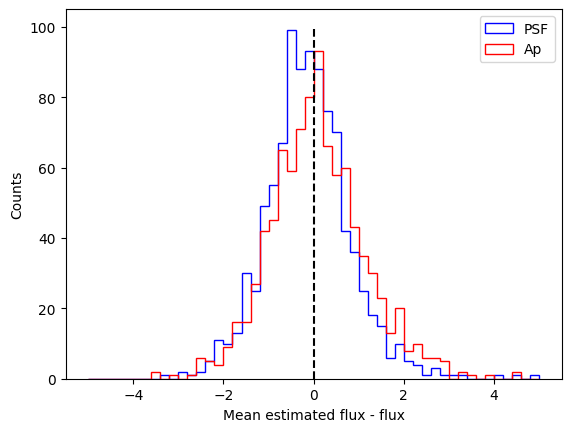

In [11]:
# Plot of estimated - actual fluxes
plt.hist((psf_data.meanflux - psf_data.flux)/psf_data.avgdflux, bins=50, histtype='step', 
         range=(-5,5), color='b', label="PSF")
plt.hist((ap_data.meanflux - ap_data.flux)/ap_data.avgdflux, bins=50, histtype='step',
         range=(-5,5), color='r', label="Ap")
plt.xlabel("Mean estimated flux - flux")
plt.ylabel("Counts")
plt.legend()

plt.plot([0,0], [0, 100], 'k--')

(-5.0, 5.0)

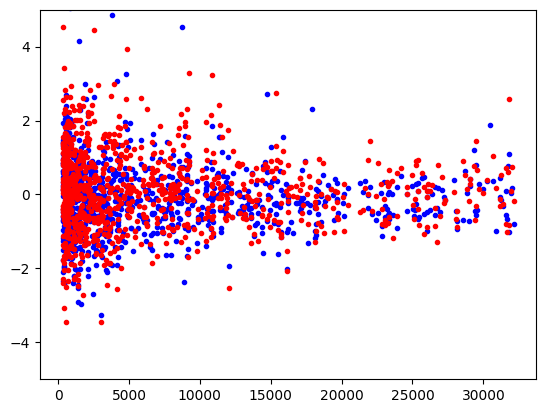

In [8]:
plt.plot(psf_data.flux, (psf_data.meanflux - psf_data.flux) / psf_data.avgdflux, 'b.', label="PSF")
plt.plot(ap_data.flux, (ap_data.meanflux - ap_data.flux) / ap_data.avgdflux, 'r.', label="Ap")
plt.ylim([-5, 5])

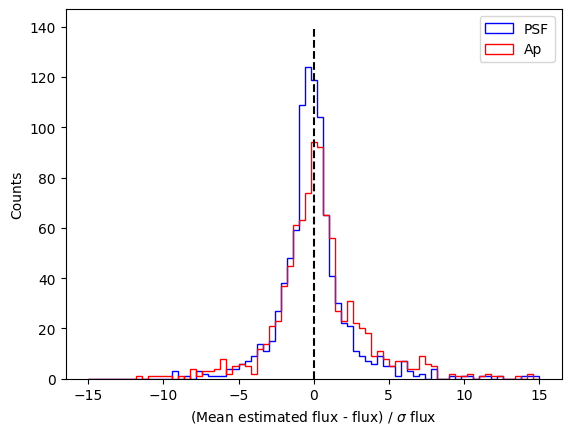

In [24]:
# Plot of estimated - actual fluxes over error
plt.hist((psf_data.meanflux - psf_data.flux)/psf_data.stdflux, bins=75, range=(-15,15), histtype='step', color='b', label="PSF")
plt.hist((ap_data.meanflux - ap_data.flux)/ap_data.stdflux, bins=75, range=(-15,15), histtype='step', color='r', label="Ap")
plt.xlabel(r"(Mean estimated flux - flux) / $\sigma$ flux")
plt.ylabel("Counts")
plt.legend()

plt.plot([0,0], [0, 140], 'k--')